In [1]:
using MLDataPattern
using Plots; pyplot()
using ProgressMeter
using JLD
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

true

In [2]:
import Nets
reload("Nets")

In [3]:
include("../../pympc.jl")
colmat = PyMPC.colmat

Test Summary:    | Pass  Total
test sensitivity |  267    267


colmat (generic function with 1 method)

In [4]:
sys = PyMPC.Models.HybridCartPole();

In [5]:
vis = Visualizer()[:cartpole]
setgeometry!(vis, sys)
settransform!(vis, sys, [0, 0]);

In [6]:
controller = PyMPC.Models.controller(sys)

PyObject <pympc.control.MPCHybridController instance at 0x1288bf4d0>

In [7]:
x_0 = [0., 0.1, 2.1, 0.]
xs = PyMPC.Models.simulate(sys, x_0, controller; N_sim=30);

In [8]:
PyMPC.Models.playback(vis, sys, xs)

In [9]:
# num_samples = 100
# data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

# @showprogress for i in 1:num_samples
#     while true
#         x0 = PyMPC.Models.generate_x0(sys)
#         u, J, x_traj = PyMPC.run_mpc(controller, x0)
#         if !isnan(u[1])
#             PyMPC.Models.playback(vis, sys, vec.(x_traj))
#             push!(data, (x0, hcat(u, J[1:length(u), :])))
#             for x in x_traj
#                 u, J, _ = PyMPC.run_mpc(controller, vec(x))
#                 if !isnan(u[1])
#                     push!(data, (vec(x), hcat(u, J[1:length(u), :])))
#                 end
#             end
#             break
#         end
#     end
# end

# save("cart_pole_100_traj.jld", "data", data)

In [10]:
data = load("cart_pole_100_traj.jld")["data"]
train_data, test_data = splitobs(shuffleobs(data), 0.5)

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

AffineMap([0.0114567], [0.0])

In [27]:
widths = [4, 16, 16, 16, 1]

function sensitive_loss(λ)
    q = [1.0-λ λ λ λ λ]
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [96]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 200;

mean((xy->begin  # In[114], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 254.6902082716946


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

mean((xy->begin  # In[114], line 16:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 37.35817409661158


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26



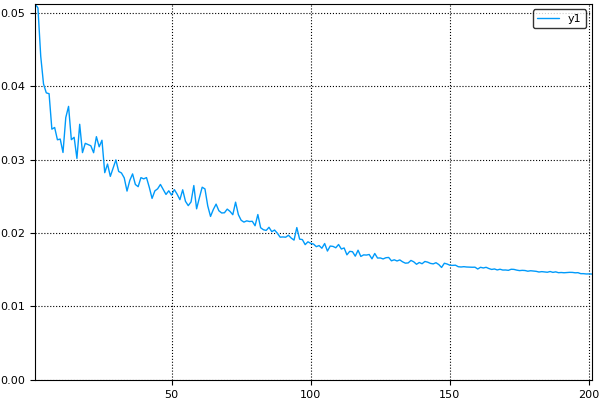

In [114]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

# train_loss = sensitive_loss(0.0)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    train_loss = sensitive_loss(0.1)
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.98^i, batch_size=5))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))

In [164]:
x0 = PyMPC.Models.generate_x0(sys)
for i in 1:100
    x0 = PyMPC.Models.generate_x0(sys)
    if !any(isnan, controller[:feedback](colmat(x0)))
        break
    end
end

In [165]:
xs = PyMPC.Models.simulate(sys, x0, net; N_sim=100)
PyMPC.Models.playback(vis, sys, xs)

In [42]:
xs = PyMPC.Models.simulate(sys, x0, controller; N_sim=100)
PyMPC.Models.playback(vis, sys, xs)